In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from typing import List, Tuple

In [25]:
SIMILARITY_THRESHOLD = 0.9
TREND_THRESHOLD = 0.02
N_SIMILAR_VECTORS = 10

In [27]:
class TradingStrategy:
    def __init__(self, historical_vectors: np.array, historical_returns: np.array):
        self.historical_vectors = historical_vectors
        self.historical_returns = historical_returns
    
    def find_similar_vectors(self, current_vector: np.array) -> List[Tuple[int, float]]:
        """Find the N most similar historical vectors"""
        similarities = cosine_similarity([current_vector], self.historical_vectors)[0]
        top_indices = np.argsort(similarities)[-N_SIMILAR_VECTORS:]
        return [(i, similarities[i]) for i in top_indices if similarities[i] > SIMILARITY_THRESHOLD]
    
    def predict_trend(self, similar_indices: List[Tuple[int, float]]) -> float:
        """Predict trend based on similar historical vectors"""
        if not similar_indices:
            return 0
        
        weighted_returns = sum(self.historical_returns[i] * sim for i, sim in similar_indices)
        total_similarity = sum(sim for _, sim in similar_indices)
        return weighted_returns / total_similarity if total_similarity > 0 else 0
    
    def make_trading_decision(self, predicted_trend: float) -> str:
        """Make a trading decision based on the predicted trend"""
        if predicted_trend > TREND_THRESHOLD:
            return "BUY"
        elif predicted_trend < -TREND_THRESHOLD:
            return "SELL"
        else:
            return "HOLD"
    
    def execute_strategy(self, current_vector: np.array) -> Tuple[str, float]:
        """Execute the trading strategy for the current vector"""
        similar_vectors = self.find_similar_vectors(current_vector)
        predicted_trend = self.predict_trend(similar_vectors)
        decision = self.make_trading_decision(predicted_trend)
        return decision, predicted_trend

# Initialize the strategy
strategy = TradingStrategy(historical_vectors, historical_returns)

In [28]:
def simulate_trading(strategy: TradingStrategy, n_periods: int) -> pd.DataFrame:
    results = []
    for i in range(n_periods):
        current_vector = np.random.rand(vector_size)  # Simulate new market data
        decision, predicted_trend = strategy.execute_strategy(current_vector)
        results.append({
            'period': i,
            'decision': decision,
            'predicted_trend': predicted_trend
        })
    return pd.DataFrame(results)

# Run simulation
simulation_results = simulate_trading(strategy, n_periods=100)
print(simulation_results.head())

   period decision  predicted_trend
0       0     HOLD                0
1       1     HOLD                0
2       2     HOLD                0
3       3     HOLD                0
4       4     HOLD                0


Decision counts:
decision
HOLD    100
Name: count, dtype: int64


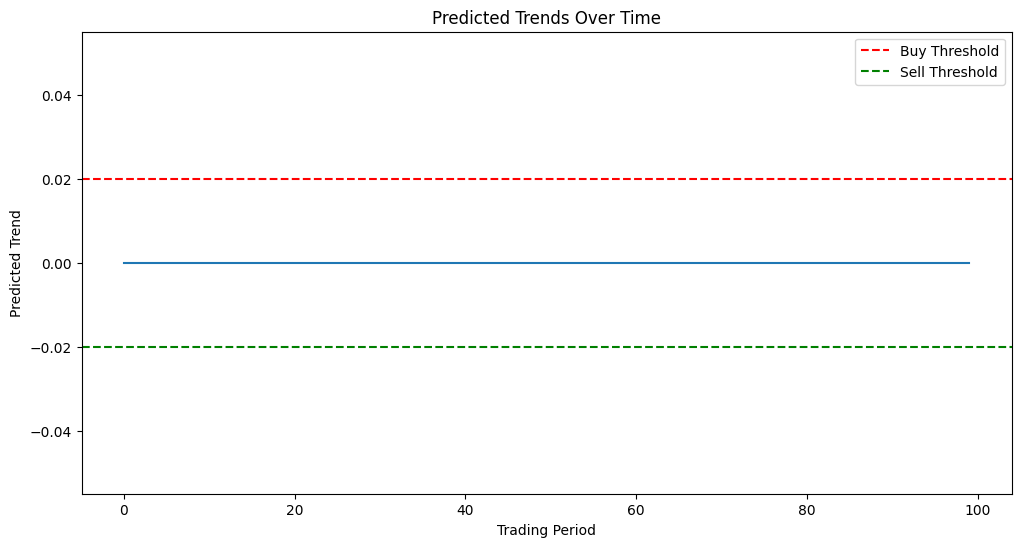

In [29]:
decision_counts = simulation_results['decision'].value_counts()
print("Decision counts:")
print(decision_counts)

# Plot predicted trends
plt.figure(figsize=(12, 6))
plt.plot(simulation_results['period'], simulation_results['predicted_trend'])
plt.title('Predicted Trends Over Time')
plt.xlabel('Trading Period')
plt.ylabel('Predicted Trend')
plt.axhline(y=TREND_THRESHOLD, color='r', linestyle='--', label='Buy Threshold')
plt.axhline(y=-TREND_THRESHOLD, color='g', linestyle='--', label='Sell Threshold')
plt.legend()
plt.show()

In [30]:
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [31]:
def load_real_data(file_path: str) -> Tuple[np.array, np.array]:
    # Load data from CSV file
    df = pd.read_csv(file_path)
    
    # Assume the CSV has columns for each feature in the vector representation
    # and a 'returns' column for the corresponding returns
    vector_columns = [col for col in df.columns if col.startswith('feature_')]
    
    vectors = df[vector_columns].values
    returns = df['returns'].values
    
    return vectors, returns
# historical_vectors, historical_returns = load_real_data('path_to_your_data.csv')

In [32]:
def advanced_similarity(vector1: np.array, vector2: np.array) -> float:
    cosine_sim = cosine_similarity([vector1], [vector2])[0][0]
    pearson_corr, _ = pearsonr(vector1, vector2)
    return (cosine_sim + pearson_corr) / 2

class EnhancedTradingStrategy(TradingStrategy):
    def find_similar_vectors(self, current_vector: np.array) -> List[Tuple[int, float]]:
        similarities = [advanced_similarity(current_vector, hist_vector) 
                        for hist_vector in self.historical_vectors]
        top_indices = np.argsort(similarities)[-N_SIMILAR_VECTORS:]
        return [(i, similarities[i]) for i in top_indices if similarities[i] > SIMILARITY_THRESHOLD]

In [34]:
def kelly_criterion(win_rate: float, win_loss_ratio: float) -> float:
    return win_rate - ((1 - win_rate) / win_loss_ratio)

class RiskManagedStrategy(EnhancedTradingStrategy):
    def __init__(self, historical_vectors: np.array, historical_returns: np.array):
        super().__init__(historical_vectors, historical_returns)
        self.win_rate = 0.5  # Initial estimate, update this based on backtesting results
        self.win_loss_ratio = 1.5  # Initial estimate, update this based on backtesting results
    
    def execute_strategy(self, current_vector: np.array) -> Tuple[str, float, float]:
        decision, predicted_trend = super().execute_strategy(current_vector)
        kelly_fraction = kelly_criterion(self.win_rate, self.win_loss_ratio)
        position_size = max(0, min(kelly_fraction, 1))  # Ensure position size is between 0 and 1
        return decision, predicted_trend, position_size

# Usage:
# risk_managed_strategy = RiskManagedStrategy(historical_vectors, historical_returns)

In [36]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [37]:
def fetch_real_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start_date, end=end_date, interval='15m')
    data['Returns'] = data['Close'].pct_change()
    return data

def create_vector_representation(data: pd.DataFrame, window: int = 20) -> Tuple[np.array, np.array]:
    features = [
        data['Returns'].rolling(window=window).mean(),
        data['Returns'].rolling(window=window).std(),
        data['Volume'].rolling(window=window).mean(),
        data['High'].div(data['Low']).rolling(window=window).mean(),
        (data['Close'] - data['Open']).div(data['Open']).rolling(window=window).mean()
    ]
    
    vectors = np.column_stack(features)
    vectors = vectors[window-1:]  # Remove NaN rows
    returns = data['Returns'].iloc[window:].values
    
    return vectors, returns

# Usage:
# data = fetch_real_data('AAPL', '2023-01-01', '2023-12-31')
# vectors, returns = create_vector_representation(data)
# strategy = RiskManagedStrategy(vectors[:-100], returns[:-100])  # Use last 100 periods for testing
# test_results = backtest_with_costs(strategy, vectors[-100:], returns[-100:])


In [38]:
from itertools import product

def optimize_parameters(vectors: np.array, returns: np.array, 
                        param_grid: dict) -> Tuple[dict, float]:
    best_params = {}
    best_sharpe = -np.inf
    
    param_combinations = product(*param_grid.values())
    
    for params in param_combinations:
        param_dict = dict(zip(param_grid.keys(), params))
        
        strategy = RiskManagedStrategy(vectors[:-100], returns[:-100])
        strategy.SIMILARITY_THRESHOLD = param_dict['similarity_threshold']
        strategy.TREND_THRESHOLD = param_dict['trend_threshold']
        strategy.N_SIMILAR_VECTORS = param_dict['n_similar_vectors']
        
        results = backtest_with_costs(strategy, vectors[-100:], returns[-100:])
        sharpe_ratio = calculate_sharpe_ratio(results['portfolio_value'])
        
        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_params = param_dict
    
    return best_params, best_sharpe

def calculate_sharpe_ratio(portfolio_values: np.array, risk_free_rate: float = 0.02) -> float:
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Usage:
# param_grid = {
# Calculate similarity with historical vectors
#     'trend_threshold': [0.01, 0.02, 0.03, 0.04],
#     'n_similar_vectors': [5, 10, 15, 20]
# }
# best_params, best_sharpe = optimize_parameters(vectors, returns, param_grid)
# print(f"Best parameters: {best_params}")
# print(f"Best Sharpe ratio: {best_sharpe}")

In [39]:
class AdvancedRiskManagedStrategy(RiskManagedStrategy):
    def __init__(self, historical_vectors: np.array, historical_returns: np.array,
                 stop_loss: float = 0.02, take_profit: float = 0.05):
        super().__init__(historical_vectors, historical_returns)
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.entry_price = None
    
    def execute_strategy(self, current_vector: np.array, current_price: float) -> Tuple[str, float, float]:
        decision, predicted_trend, position_size = super().execute_strategy(current_vector)
        
        if self.entry_price is None:
            self.entry_price = current_price
        
        # Check for stop-loss or take-profit
        if self.entry_price is not None:
            price_change = (current_price - self.entry_price) / self.entry_price
            if abs(price_change) >= self.stop_loss or price_change >= self.take_profit:
                decision = "SELL" if price_change > 0 else "BUY"  # Close the position
                self.entry_price = None
        
        return decision, predicted_trend, position_size

# Usage in backtesting:
# def backtest_with_advanced_risk(strategy: AdvancedRiskManagedStrategy, test_vectors: np.array, 
#                                 test_returns: np.array, test_prices: np.array) -> pd.DataFrame:
#     # Similar to previous backtest function, but pass current_price to execute_strategy
#     # and handle the stop-loss and take-profit logic